# Part 1 (Data Collection, Processing, and Resampling)

## Imports

In [3]:
import requests
from abc import ABC, abstractmethod
import time
import binance
import pandas as pd
from requests.exceptions import ConnectTimeout
from tqdm import tqdm
import mplfinance as mpf
import os

## Constants

### Time Intervals

In [61]:
from datetime import datetime

start_date = datetime(2024, 1, 1)
finish_date = datetime(2024, 2, 1)

start_seconds = int(start_date.timestamp())
finish_seconds = int(finish_date.timestamp())

start_ms = int(start_date.timestamp() * 1000)
finish_ms = int(finish_date.timestamp() * 1000)

### Others

In [4]:
DATA_DIR = 'data/raw'

## APIs

### Nobitex

In [55]:
class NobitexAPI(ABC):
    base_url = 'https://chart.nobitex.ir'

    def __init__(self, data, status, errmsg=None):
        self.data = data
        self.status = status
        self.errmsg = errmsg

    def __repr__(self):
        return f"{self.__class__.__name__}(status={self.status}, data={self.data}, errmsg={self.errmsg})"

    @classmethod
    @abstractmethod
    def fetch(cls, **kwargs):
        """Fetch data from Nobitex API. Must be implemented by subclasses."""
        pass

    @classmethod
    def get(cls, endpoint, params):
        """Generic GET request method."""
        url = f"{cls.base_url}{endpoint}"
        url_with_params = requests.Request('GET', url, params=params).prepare().url
        
        # Print the full URL with parameters
        print(f"Fetching: {url_with_params}")
        
        response = requests.get(url, params=params)
        data = response.json()
        return data

class NobitexMarketHistory(NobitexAPI):
    @classmethod
    def fetch(cls, symbol, resolution, to, from_=None, countback=None, page=1):
        # Ensure resolution is in the correct format
        if isinstance(resolution, int):
            resolution = str(resolution)

        # Define maximum 40-day interval in seconds (40 days * 24 hours * 60 minutes * 60 seconds)
        max_interval = 30 * 24 * 60 * 60

        data = []
        current_from = from_
        current_to = min(to, current_from + max_interval)
        
        while current_from < to:
            endpoint = '/market/udf/history'
            params = {
                'symbol': symbol,
                'resolution': resolution,
                'from': current_from,
                'to': current_to,
                'countback': countback,
                'page': page
            }
            params = {k: v for k, v in params.items() if v is not None}
            
            # Use the generic get method from NobitexAPI
            result = cls.get(endpoint, params)
            
            # Process result
            if result.get('s') == 'ok':
                # Combine all data fields into a list of dictionaries
                combined_data = [
                    {
                        'open_time': t,
                        'open': o,
                        'high': h,
                        'low': l,
                        'close': c,
                        'volume': v,
                    }
                    for t, o, h, l, c, v in zip(result['t'], result['o'], result['h'], result['l'], result['c'], result['v'])
                ]
                data.extend(combined_data)
            elif result.get('s') == 'error':
                return cls(data=None, status='error', errmsg=result.get('errmsg'))
            elif result.get('s') == 'no_data':
                return cls(data=None, status='no_data')
            
            # Update the from and to timestamps for the next request
            current_from = current_to
            current_to = min(to, current_from + max_interval)
            time.sleep(1)  # Avoid hitting API rate limits

        return cls(data=data, status='ok')

    def to_dataframe(self):
        """Convert data to pandas DataFrame with specified columns."""
        df = pd.DataFrame(self.data)
        return df

In [ ]:
nobitex_history = NobitexMarketHistory.fetch(symbol='BTCIRT', resolution='1', from_=start_seconds, to=start_seconds+(30 * 24 * 60 * 60))
len(nobitex_history.data)

### Binance

#### Client

In [14]:
binance_client = binance.Client()

#### Fetch Data

In [16]:
def fetch_binance_data(symbol, interval, start_ms, finish_ms):
    all_klines = []

    # Approximate number of iterations (assuming 1 minute interval and 1000 klines per request)
    total_iterations = (finish_ms - start_ms) // (60000 * 1000)
    
    with tqdm(total=total_iterations) as pbar:
        while True:
            try:
                klines = binance_client.get_klines(symbol=symbol, interval=interval, startTime=start_ms, endTime=finish_ms, limit=1000)
                if not klines:
                    print("No more data returned.")
                    break

                all_klines.extend(klines)
                start_ms = klines[-1][6] + 1
                pbar.update(1)  # Update the progress bar for each iteration

                if klines[-1][6] >= finish_ms:
                    print("Reached the end of the specified time range.")
                    break
            except ConnectTimeout:
                print("Connection timed out. Retrying...")
                time.sleep(5)
            except Exception as e:
                print(f"An error occurred: {e}")
                break

    if all_klines:
        df = pd.DataFrame(all_klines, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        return df
    else:
        print("No data was fetched.")
        return pd.DataFrame()

In [52]:
symbol = 'BTCUSDT'
interval = binance_client.KLINE_INTERVAL_1MINUTE

binance_df = fetch_binance_data(symbol, interval, start_ms, finish_ms)

526it [04:24,  1.99it/s]                         


Reached the end of the specified time range.


In [53]:
print(binance_df.shape)
binance_df.head()

(525521, 12)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2022-11-30 20:30:00,17064.40000000,17065.99000000,17047.60000000,17050.44000000,209.86552000,2022-11-30 20:30:59.999,3579674.71396160,4407,79.37261000,1353883.97241390,0
1,2022-11-30 20:31:00,17050.44000000,17053.84000000,17041.58000000,17050.30000000,337.00599000,2022-11-30 20:31:59.999,5745218.75132600,5183,134.70981000,2296579.72240950,0
2,2022-11-30 20:32:00,17050.30000000,17058.24000000,17048.29000000,17054.85000000,97.75362000,2022-11-30 20:32:59.999,1667039.76997760,3120,54.26572000,925442.80341800,0
3,2022-11-30 20:33:00,17054.85000000,17063.32000000,17052.69000000,17061.22000000,98.22312000,2022-11-30 20:33:59.999,1675551.07662580,2885,55.13708000,940602.14092560,0
4,2022-11-30 20:34:00,17061.22000000,17071.70000000,17059.10000000,17064.20000000,199.67957000,2022-11-30 20:34:59.999,3407625.00355910,3681,120.19123000,2051148.33435440,0


#### Save CSV

In [55]:
binance_df.to_csv(DATA_DIR + f'Binance-{symbol}.csv')

#### Load & Pre-Process

In [57]:
def load_and_preprocess_binance_data(file_name='Binance-BTCUSDT.csv'):
    global binance_df
    
    if 'binance_df' not in globals():
        file_path = os.path.join(DATA_DIR, file_name)
        
        if os.path.exists(file_path):
            binance_df = pd.read_csv(file_path)
            print(f"Loaded data from {file_path}")
        else:
            print(f"File {file_path} does not exist. Check the path.")
            return
    else:
        print("binance_df is already defined.")

    binance_df['open_time'] = pd.to_datetime(binance_df['open_time'], unit='ms')
    binance_df['close_time'] = pd.to_datetime(binance_df['close_time'], unit='ms')
    
    columns_to_convert = ['open', 'high', 'low', 'close', 'volume', 
                        'quote_asset_volume', 'number_of_trades', 
                        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
    binance_df[columns_to_convert] = binance_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
    
    binance_df.dropna(inplace=True)
    print("Data preprocessing complete.")

In [58]:
load_and_preprocess_binance_data()

binance_df is already defined.
Data preprocessing complete.


#### Visualization

In [59]:
def plot_candles(df):
    if df.empty:
        print("The DataFrame is empty. No data to plot.")
        return
    
    df = df.set_index('open_time')
    df.index.name = 'Date'
    df = df[['open', 'high', 'low', 'close', 'volume']]
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    mpf.plot(df, type='candle', volume=True, style='charles', title=f'Candles')

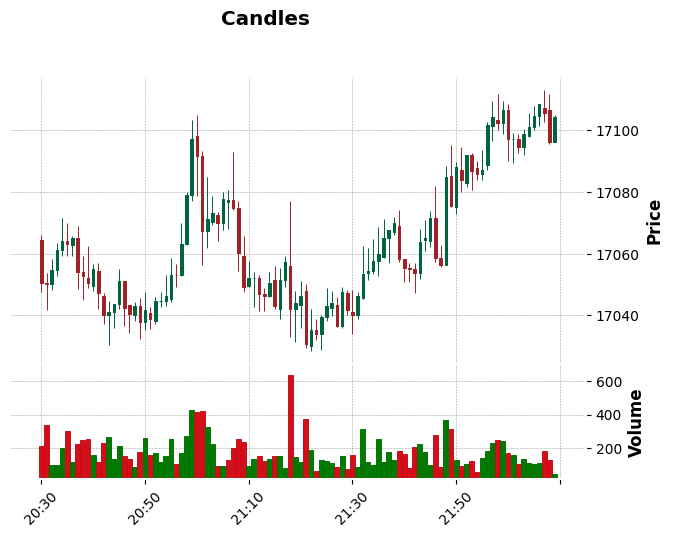

In [60]:
plot_candles(binance_df[:100])

## Handling Missing Data

To address missing candles in a time series dataset, particularly for financial data like Bitcoin trading, it's crucial to maintain the continuity and integrity of the data series. Here are a couple of simple strategies that can be used to fill in missing data:

1. Carry Forward the Last Known Value (Last Observation Carried Forward - LOCF)
    In this method, if a time interval is missing, the data from the last available interval is carried forward to fill the gap. This approach assumes that the market conditions did not change significantly between the missing intervals.

2. Simple Average of Adjacent Data Points
    This method uses the average of the data points before and after the missing interval to fill the gap. It assumes that the missing data is likely to be similar to the average of the surrounding points.

Considerations
- Granularity: Given that the data is on a one-minute scale, gaps might not significantly impact the analysis if they are sparse.
- Market Conditions: Financial markets can change rapidly, so the chosen method should be as accurate as possible, given the limitations.

In [10]:
missing_df = pd.read_csv(r'data\raw data\btctmn_m1_tabdeal.csv')
missing_df.set_index('datetime', inplace=True)

In [11]:
if not isinstance(missing_df.index, pd.DatetimeIndex):
    missing_df.index = pd.to_datetime(missing_df.index)

In [12]:
missing_df

,open,high,low,close,volume,exchange,isin
datetime,,,,,,,
2024-03-07 00:04:00,4.043117e+09,4.043117e+09,4.029734e+09,4.029734e+09,0.000629,tabdeal,BTCTMN
2024-03-07 00:06:00,4.029734e+09,4.032187e+09,4.029734e+09,4.032187e+09,0.002161,tabdeal,BTCTMN
2024-03-07 00:07:00,4.032187e+09,4.032187e+09,4.029733e+09,4.029733e+09,0.000015,tabdeal,BTCTMN
2024-03-07 00:08:00,4.029733e+09,4.029733e+09,4.024795e+09,4.024795e+09,0.000070,tabdeal,BTCTMN
2024-03-07 00:09:00,4.024795e+09,4.024795e+09,4.023868e+09,4.023868e+09,0.000076,tabdeal,BTCTMN
...,...,...,...,...,...,...,...
2024-02-28 23:54:00,3.547556e+09,3.547556e+09,3.542859e+09,3.542859e+09,0.006455,tabdeal,BTCTMN
2024-02-28 23:55:00,3.542859e+09,3.542859e+09,3.537971e+09,3.537971e+09,0.044727,tabdeal,BTCTMN
2024-02-28 23:56:00,3.537971e+09,3.537971e+09,3.519652e+09,3.527862e+09,0.010667,tabdeal,BTCTMN


In [15]:
df_ffill = missing_df.resample('1T').ffill()

C:\Users\Shayan\AppData\Local\Temp\ipykernel_21920\3441750221.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_ffill = missing_df.resample('1T').ffill()


In [14]:
df_interpolated = missing_df.resample('1T').interpolate(method='linear')

C:\Users\Shayan\AppData\Local\Temp\ipykernel_21920\3613154220.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_interpolated = missing_df.resample('1T').interpolate(method='linear')
C:\Users\Shayan\AppData\Local\Temp\ipykernel_21920\3613154220.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = missing_df.resample('1T').interpolate(method='linear')


## Implied USDT-TMN Extraction

In [ ]:
btc_usdt = pd.read_csv('btc_usdt.csv')
btc_tmn = pd.read_csv('btc_tmn.csv')

In [ ]:
btc_usdt_close = btc_usdt['close']
btc_tmn_close = btc_tmn['close']

In [ ]:
btc_usdt['open_time'] = pd.to_datetime(btc_usdt['open_time'], unit='ms')
btc_tmn['datetime'] = pd.to_datetime(btc_tmn['datetime'])

In [ ]:
usdt_tmn_exchange_rate = btc_tmn_close / btc_usdt_close
usdt_tmn_price_change = usdt_tmn_exchange_rate.pct_change()